In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
#supress update on pandas regarding TargetEncoding
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#dropping irrelevant columns, including region, can use state instead.  Region is messy with lots of random values
#dropping size column because majority is empty
#posting date has only 2021 postings
#check columns on Kaggle for info before reading it in

data = pd.read_csv('./vehicles.csv',
                   usecols=['price', 'year', 'manufacturer', 'model', 'condition', 
                            'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
                            'drive', 'type', 'paint_color', 'state'], nrows = 200000)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         200000 non-null  int64  
 1   year          199226 non-null  float64
 2   manufacturer  191262 non-null  object 
 3   model         197589 non-null  object 
 4   condition     121294 non-null  object 
 5   cylinders     117398 non-null  object 
 6   fuel          198967 non-null  object 
 7   odometer      197852 non-null  float64
 8   title_status  195808 non-null  object 
 9   transmission  198932 non-null  object 
 10  drive         137638 non-null  object 
 11  type          157608 non-null  object 
 12  paint_color   140942 non-null  object 
 13  state         200000 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 21.4+ MB


# Inspecting Target

## Upper Bound

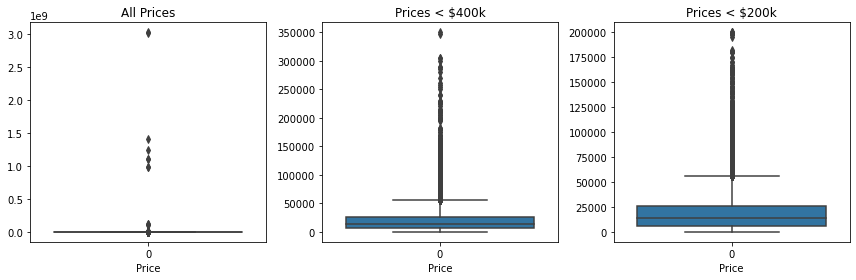

In [2]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

sns.boxplot(data=data.price, ax=ax1)
ax1.set_title('All Prices')
ax1.set_xlabel('Price')

sns.boxplot(data=data.loc[data.price < 400000,'price'], ax=ax2)
ax2.set_title('Prices < $400k')
ax2.set_xlabel('Price')

sns.boxplot(data=data.loc[data.price < 200000,'price'], ax=ax3)
ax3.set_title('Prices < $200k')
ax3.set_xlabel('Price')

fig.tight_layout()
plt.show()

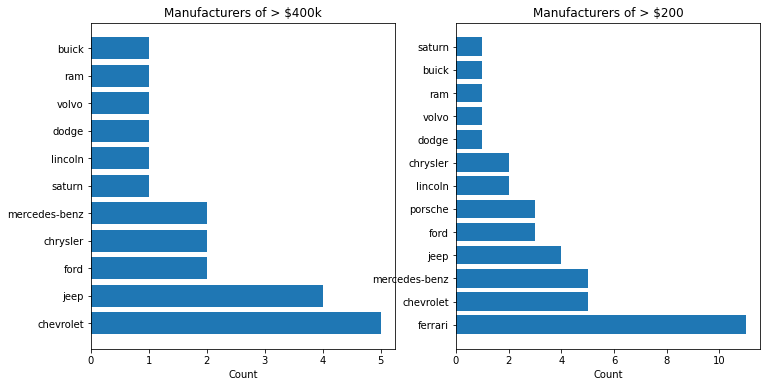

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

hist = data.loc[data.price > 400000, 'manufacturer'].value_counts()
ax1.barh(y=hist.index, width=hist.values)
ax1.set_title('Manufacturers of > $400k')
ax1.set_xlabel('Count')

hist = data.loc[data.price > 200000, 'manufacturer'].value_counts()
ax2.barh(y=hist.index, width=hist.values)
ax2.set_title('Manufacturers of > $200')
ax2.set_xlabel('Count')
plt.show()

#values are bogus so dropping anything above 400k!!!!!!!!!!!!!!!!!!!
data = data[data.price < 400000]

## Lower Bound

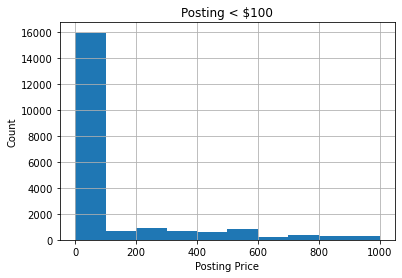

In [4]:
data.loc[data.price < 1000, 'price'].hist()
ax = plt.gca()
ax.set_title('Posting < $100')
ax.set_xlabel('Posting Price')
ax.set_ylabel('Count')

#Dropping anything below $100!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
data = data[data.price > 100]

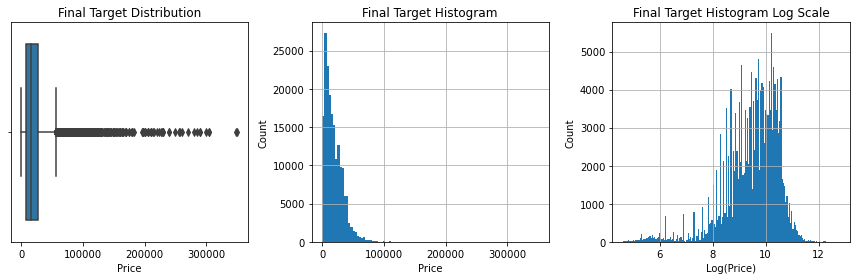

In [5]:
#dropping rows with less than 3 values!!!!!!!!!!!!!!!!!!!!!!!!!!
data.dropna(axis=0, how='any', thresh=3, inplace=True)

#prices seem reasonable, so keeping the rest of the rows
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
sns.boxplot(x=data.price, ax=ax1)
ax1.set_title('Final Target Distribution')
ax1.set_xlabel('Price')

data.price.hist(bins=100, ax=ax2)
ax2.set_title('Final Target Histogram')
ax2.set_xlabel('Price')
ax2.set_ylabel('Count')

np.log(data.price).hist(bins='auto', ax=ax3)
ax3.set_title('Final Target Histogram Log Scale')
ax3.set_xlabel('Log(Price)')
ax3.set_ylabel('Count')

fig.tight_layout()

# Categorical Cols

In [6]:
X = data.loc[:, 'year':]
y = data.loc[:,'price']

#Checking distinct values to see if can do histogram
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
num_cols = X.select_dtypes(np.number).columns.to_list()

print('Count of unique in each column:')
X[cat_cols].nunique(axis=0)

Count of unique in each column:


manufacturer       42
model           17957
condition           6
cylinders           8
fuel                5
title_status        6
transmission        3
drive               3
type               13
paint_color        12
state              23
dtype: int64

In [7]:
nas = sum(X.manufacturer.isna())
print(f'Initial Manufacturer NA Count: {nas}')
X[X.manufacturer.isna()].head()

Initial Manufacturer NA Count: 7672


,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
97,2016.0,NaN,Scion iM Hatchback 4D,good,NaN,gas,29652.0,clean,other,fwd,hatchback,blue,al
122,2005.0,NaN,blue bird bus,excellent,6 cylinders,diesel,180000.0,clean,automatic,rwd,bus,yellow,al
135,2016.0,NaN,Scion iM Hatchback 4D,good,NaN,gas,65203.0,clean,other,fwd,hatchback,red,al
137,1966.0,NaN,1966 C-30 1 ton,good,6 cylinders,gas,47000.0,clean,manual,rwd,pickup,brown,al
155,2013.0,NaN,smart fortwo Passion Hatchback,good,NaN,gas,59072.0,clean,automatic,rwd,coupe,silver,al


In [8]:
#2 options
#1. Mapping will contain actual manufacturer
#2. Mapping might contain a model that has a manufacturer in another row

#filling in #2 scenario
X['mapping'] = X.model.str.replace(',',' ').str.split().str[0].str.lower()

#helper will have mapping between models and manufacturers
helper = X.loc[~X.manufacturer.isna(), ['manufacturer', 'model']].drop_duplicates()
helper.drop_duplicates(subset='model', inplace=True)
helper.set_index('model', inplace=True)

#mapping and filling in manufacturer where found model in previous rows
X.loc[X.manufacturer.isna(), 'manufacturer'] = X['mapping'].map(helper.manufacturer, na_action='ignore')

#Checking if there are cars without manufacturer and mapping/model
#Need to fill in empty mapping with manufacturer to then filter out numeric strings
#Value that aren't numeric will be set as manufacturer
X[(X.manufacturer.isna()) & (X.mapping.isna())]

#Num of manufacturers that were filled in from mapping models
nas2 = sum(X.manufacturer.isna())
print(f'Rows filled in after mapping: {nas - nas2}')

#filling in the rest of missing manufacturers with 'NA'
X.manufacturer.fillna('NA', inplace=True)
X.model.fillna('NA', inplace=True)
X.drop(columns='mapping', inplace=True)

Rows filled in after mapping: 2554


Model Counts: 17958


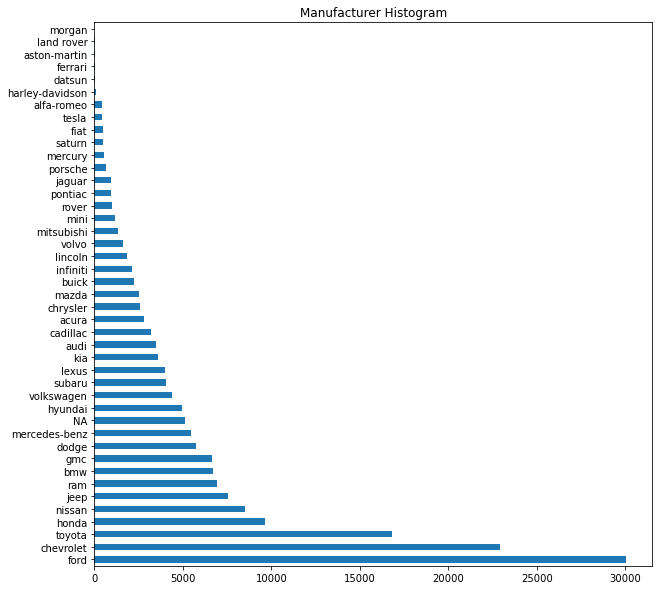

In [9]:
X.manufacturer.value_counts().plot(kind='barh', figsize=(10,10))
plt.gca().set_title('Manufacturer Histogram')

models = len(X.model.unique())
print(f'Model Counts: {models}')

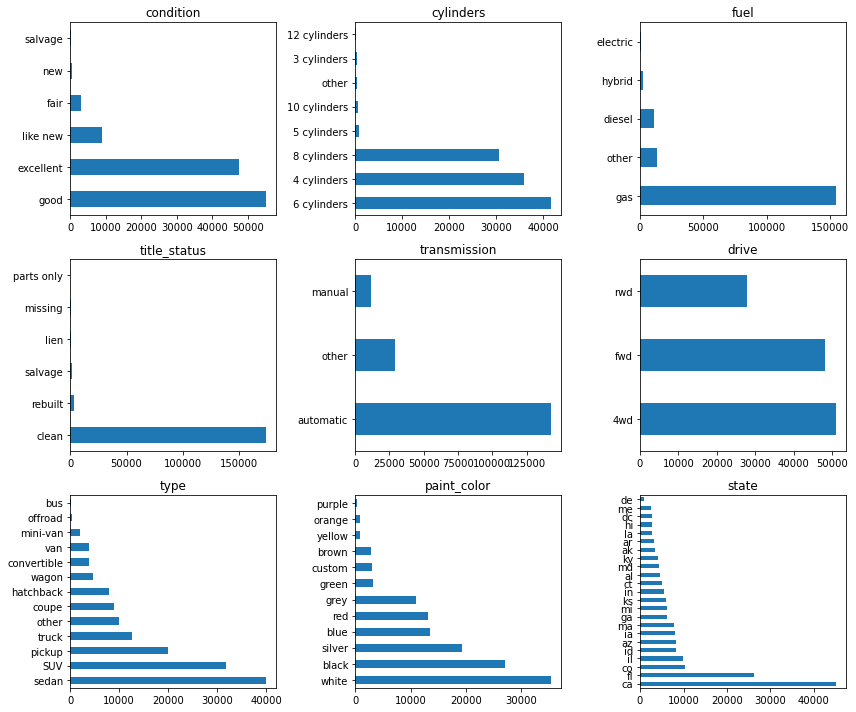

In [10]:
fig, axs = plt.subplots(3,3, figsize=(12,10))
for col, ax in zip(cat_cols[2:], axs.ravel()):
    X[col].value_counts().plot(kind='barh', ax=ax)
    ax.set_title(f'{col}')
fig.tight_layout()    

In [11]:
ord_cols = ['condition', 'cylinders']
targ_cols = ['state']

X.cylinders = X.cylinders.str.split().str[0]
X.cylinders.replace('other', None, inplace=True)
X.cylinders = X.cylinders.astype(float)
X.cylinders.fillna(X.cylinders.median(), inplace=True)

fill_na_cols = ['condition', 'fuel', 'title_status', 'transmission', 
                'drive', 'type', 'paint_color', 'state']
X[fill_na_cols] = X[fill_na_cols].fillna('NA')

print('NA Counts for Cat Variables')
display(X[cat_cols].isna().sum(0))

cat_cols = list(set(cat_cols) - set(ord_cols+targ_cols))

NA Counts for Cat Variables


manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

# Cont Columns

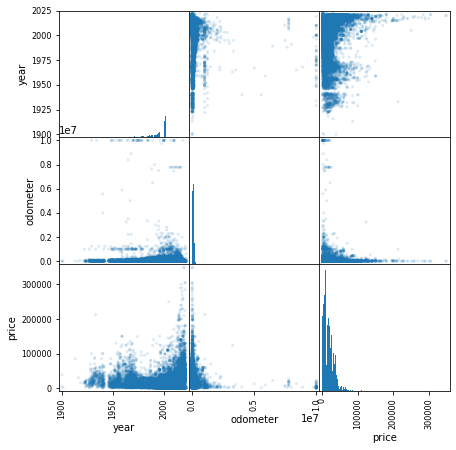

Nan Counts:
year         707
odometer    1359
dtype: int64


In [12]:
pd.plotting.scatter_matrix(X[num_cols].join(y),figsize=(7,7), alpha=0.15, hist_kwds=dict(bins='auto'))
plt.show()
print('Nan Counts:')
print(X[num_cols].isna().sum(0))

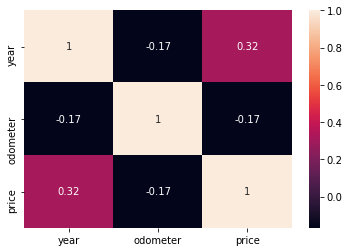

In [13]:
sns.heatmap(X[num_cols].join(y).corr(), annot=True)
#initial correlations make sense.  Negative relationship with odometer and positive with year
plt.show()

Text(0.5, 1.0, 'Odometer Distribution')

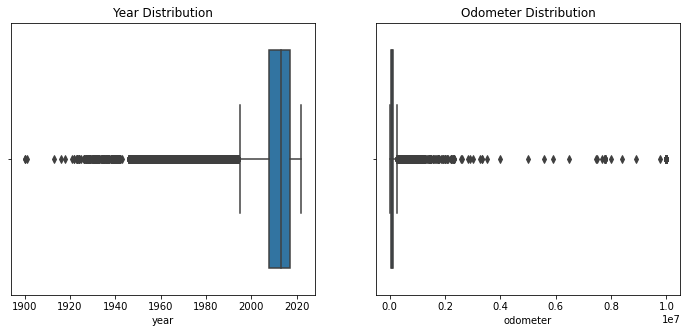

In [14]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
sns.boxplot(x=X.year, ax=axs[0])
axs[0].set_title('Year Distribution')

sns.boxplot(x=X.odometer, ax=axs[1])
axs[1].set_title('Odometer Distribution')

Odometer values and counts for milage > 1M miles


9999999.0     27
10000000.0    26
1111111.0     13
7777777.0     12
1234567.0     11
2222222.0      4
Name: odometer, dtype: int64

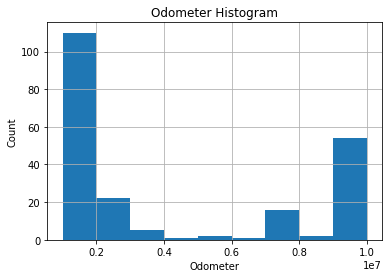

In [15]:
X.loc[X.odometer > 1000000, 'odometer'].hist(bins='auto')
ax = plt.gca()
ax.set_xlabel('Odometer')
ax.set_ylabel('Count')
ax.set_title('Odometer Histogram')

print('Odometer values and counts for milage > 1M miles')
milage = X.loc[X.odometer > 1000000, 'odometer'].value_counts()
milage[milage > 3]

Text(0.5, 0, 'Odometer')

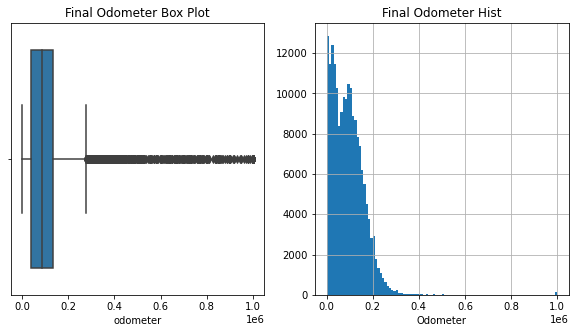

In [16]:
#milages in milage are random numbers, filling in with median of the column excluding those numbers
X.loc[X.odometer.isin(milage.index), 'odometer'] = X.loc[~X.odometer.isin(milage.index), 'odometer'].median()

fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(x = X.odometer, ax=axs[0])
axs[0].set_title('Final Odometer Box Plot')

X.odometer.hist(bins=100, ax=axs[1])
axs[1].set_title('Final Odometer Hist')
axs[1].set_xlabel('Odometer')

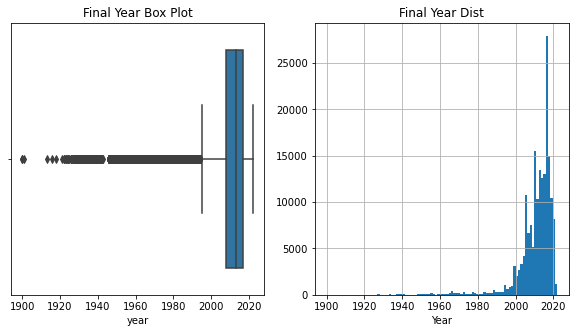

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
sns.boxplot(x = X.year, ax=axs[0])
axs[0].set_title('Final Year Box Plot')

X.year.hist(bins=100, ax=axs[1])
axs[1].set_title('Final Year Dist')
axs[1].set_xlabel('Year')

#fillilng in empty values with medians
X.fillna(dict(odometer = X.odometer.median(),
              year = X.year.median()), inplace=True)

# Models

## Linear Models

### Base

In [18]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

targ_cols = ['state', 'model', 'manufacturer']
cont = ['year', 'odometer', 'cylinders']
ohe = ['paint_color', 'type', 'drive', 'transmission', 'title_status', 'fuel', 'condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.3, test_size=0.15)

#____________________________Helper Functions_______________________________________________________________
def make_column_transformer(poly_degree=None, scaler=None):
    '''Function to create a column transformer:
        poly_degree - polynomial expansion degrees (int)
        scaler - scaler to apply to target and cont columns (Scaler)
        
        Returns:
        ColumnTransformer - ct
    '''
    target_ct = ColumnTransformer([('target', TargetEncoder(), targ_cols)], remainder='passthrough')
    ct_pipe = Pipeline([('ct', target_ct)])
    if poly_degree:
        ct_pipe.steps.append(('poly', PolynomialFeatures(degree=poly_degree)))
    if scaler:
        ct_pipe.steps.append(('scaler', scaler))
        
    ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown='ignore'), ohe),
                            ('rest', ct_pipe, targ_cols + cont)])
    return ct

def format_plots(ax, title=None, x_label=None, y_label=None):
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return    

def residuals_plots(ax1, ax2, ax3, y_t, y_predict):
    residuals = y_t - y_predict
    ax1.scatter(y_t, residuals, alpha=0.2)
    format_plots(ax1, 'Residuals', 'Y Test', 'Residuals (Test - Prediction)')
    
    ax2.hist(residuals, bins=200)
    ax2.set_xlim(min(residuals), abs(min(residuals)))
    format_plots(ax2, 'Residuals Distribution', 'Residual Bins', 'Count')
    
    sm.qqplot(residuals, line='q', ax=ax3)
    format_plots(ax3, 'Q-Q Plot', 'Theoretical Quantiles', 'Residual Quantiles')
    return

def plot_permutation_importances(ax, pipeline, X, y):
    importances = permutation_importance(pipeline, X, y)
    importances_order = np.argsort(importances['importances_mean'])
    labels = np.array(ohe+targ_cols+cont)

    ax.barh(labels[importances_order], importances['importances_mean'][importances_order], 
             xerr=importances['importances_std'][importances_order])
    format_plots(ax, 'Permutation Importances', 'Feature Importance')
    return

def print_model_scores(pipeline, model_names, X, y, cv=True):
    for model, model_name in zip(pipeline, model_names):
        cv = cross_validate(model, X, y, scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1)
        R2 = cv['test_r2'].mean()
        MAE = cv['test_neg_mean_absolute_error'].mean() * -1
        print(f'{model_name}\nR2: {R2:.3f}, MAE: {MAE:.0f}')
#___________________________________________________________________________________________________________

lr_ct = make_column_transformer()
ct = make_column_transformer(scaler=StandardScaler())

model_names = ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']
models = [Pipeline([('ct', lr_ct), ('model', LinearRegression())]),
          Pipeline([('ct', ct), ('model', RidgeCV())]),
          Pipeline([('ct', ct), ('model', LassoCV(n_jobs=-1))]),
          Pipeline([('ct', ct), ('model', ElasticNetCV(n_jobs=-1, alphas=[0.1, 1, 10], l1_ratio=0.5))])]

print_model_scores(models, model_names, X_train, y_train)

LinearRegression
R2: 0.569, MAE: 5932
Ridge
R2: 0.569, MAE: 5932
Lasso
R2: 0.568, MAE: 5925
ElasticNet
R2: 0.563, MAE: 5953


<b>Conclusions:</b>  
1. All the models score fairly poor.  Makes sense, since relationships between features and target weren't linear.  
2. Not much of improvement from linear regression to penalized models, therefore default to simpler model - Linear Regression  
3. Need to add polynomial features to see if scores will improve

### Model Tuning

C:\Users\a910045\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1925276367689.5178, tolerance: 1251129197.9449704
  positive)
C:\Users\a910045\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2080314555124.9824, tolerance: 1251129197.9449704
  positive)


LinearRegression CV Score: 0.657
Ridge CV Score: 0.666
Lasso CV Score: 0.637
ElasticNet CV Score: 0.616


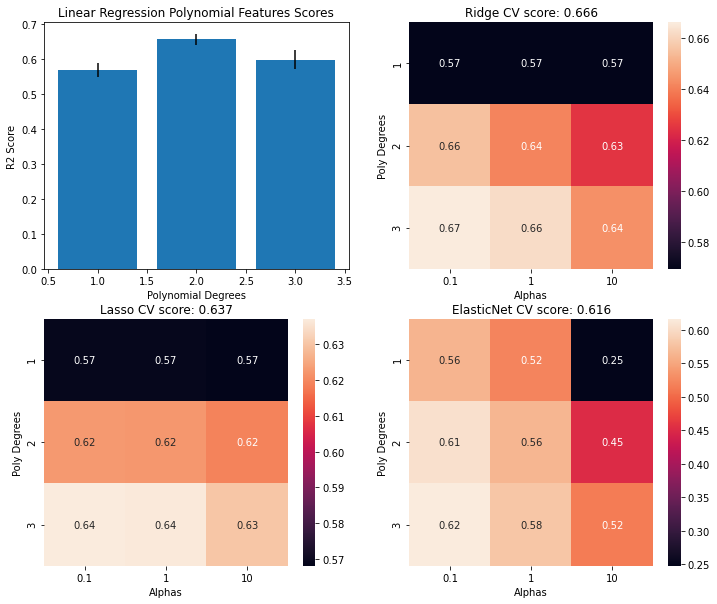

In [19]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

#prepping plots for model parameter tuning
fig, axs = plt.subplots(2,2, figsize=(12,10))
ax1, ax2, ax3, ax4 = axs.ravel()

#______________________________Linear Regression_______________________________________________________
ct = make_column_transformer(poly_degree=1)
lr = Pipeline([('ct', ct), ('model', LinearRegression())])

#setting up param grid
lr_grid_params = {'ct__rest__poly__degree':[1,2,3]}
grid = GridSearchCV(lr, param_grid=lr_grid_params)
grid.fit(X_train, y_train)
degrees = grid.cv_results_['param_ct__rest__poly__degree'].data
scores = grid.cv_results_['mean_test_score']
std_dev = grid.cv_results_['std_test_score']

ax1.bar(degrees, scores, yerr=std_dev)
format_plots(ax1, f'Linear Regression Polynomial Features Scores',
             'Polynomial Degrees', 'R2 Score')
cv_scores = [grid.best_score_]

#____________________________Penalized LR________________________________________________________
ct = make_column_transformer(1, StandardScaler())
pipes = [Pipeline([('ct', ct), ('model', Ridge())]),
         Pipeline([('ct', ct), ('model', Lasso())]),
         Pipeline([('ct', ct), ('model', ElasticNet(l1_ratio=0.5))])]

degrees = [1,2,3]
alphas = [0.1, 1, 10]
grid_params = {'ct__rest__poly__degree':degrees,
               'model__alpha':alphas}

for pipe, model_name, ax in zip(pipes, ['Ridge', 'Lasso', 'ElasticNet'], [ax2, ax3, ax4]):
        grid = GridSearchCV(pipe, param_grid=grid_params, n_jobs=2)
        grid.fit(X_train, y_train)
        test_score = grid.best_score_
        sns.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1), 
                    annot=True, xticklabels=alphas, yticklabels=degrees, ax=ax)
        format_plots(ax, f'{model_name} CV score: {test_score:.3f}',
                     'Alphas', 'Poly Degrees')
        cv_scores.append(test_score)
        
#Printing Test Scores
for score, model in zip(cv_scores, model_names):
    print(f'{model} CV Score: {score:.3f}')

<b>Take-aways:</b>  
1. Substantial improvement in score with introduction of polynomial features  
2. Linear Regression and Ridge performed the best  
3. Picking the simplest model as the main - Linear Regression w/ 2 degree Polynomial Expansion

### Model Inspection / Feature Importances

Linear Regression Test Score: 0.584


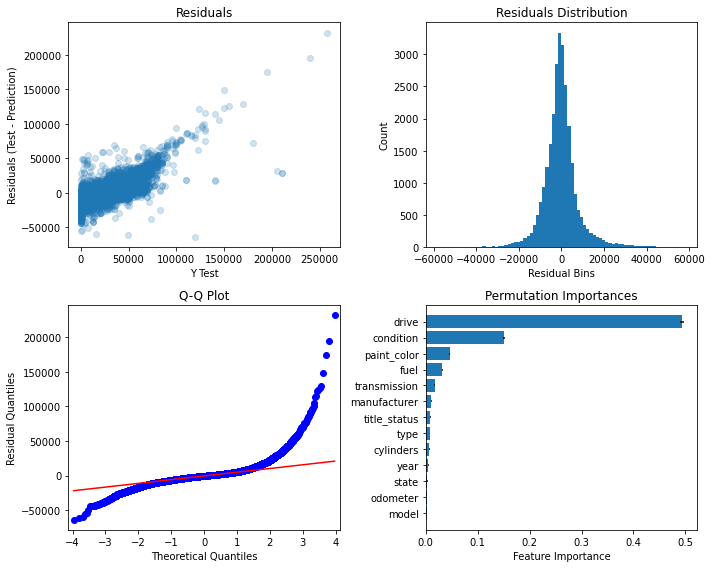

In [20]:
from sklearn.inspection import permutation_importance

ct = make_column_transformer()
lr_pipe = Pipeline([('ct', ct), ('model', LinearRegression())])
lr_pipe.fit(X_train, y_train)

fig, axs = plt.subplots(2, 2, figsize=(10,8))
ax1, ax2, ax3, ax4 = axs.ravel()

#inspecting residuals
y_predict = lr_pipe.predict(X_test)
residuals_plots(ax1, ax2, ax3, y_test, y_predict)

#Permutation imporance
plot_permutation_importances(ax4, lr_pipe, X_test, y_test)

score = lr_pipe.score(X_test, y_test)
print(f'Linear Regression Test Score: {score:.3f}')
fig.tight_layout()

<b>Take-aways:</b>
1. Linear Model with 2 degree polynomial expansions performs on par with penalized linear models  
2. Residual distribution is centered around 0, implies no systematic bias  
3. Residual distribution isn't normal and underpredicts values in Q3 and Q4 and overestimates in -Q3 and -Q4.  Otherwise does well on the rest
4. Permutation imporances suggest that Drive has the biggest impact on the model, with paint color coming in second  

## SVR

### Base

In [21]:
#SVR is slow on large data sets - will need to subsample train to create models
X_train_svr, X_val_svr, y_train_svr, y_val_svr = train_test_split(X_train, y_train, test_size=0.05,
                                                                  train_size=0.15, random_state=0)
#Need to scale variables because the algorithms rely on distances
ct = make_column_transformer(scaler=StandardScaler())
pipes = [Pipeline([('ct', ct), ('model', LinearSVR(C=100))]),
         Pipeline([('ct', ct), ('model', SVR(C=100, gamma='scale'))])]

model_names = ['LinearSVR', 'SVR']

print_model_scores(pipes, model_names, X_train_svr, y_train_svr)

LinearSVR
R2: 0.471, MAE: 6545
SVR
R2: 0.469, MAE: 6463


### Model Tuning

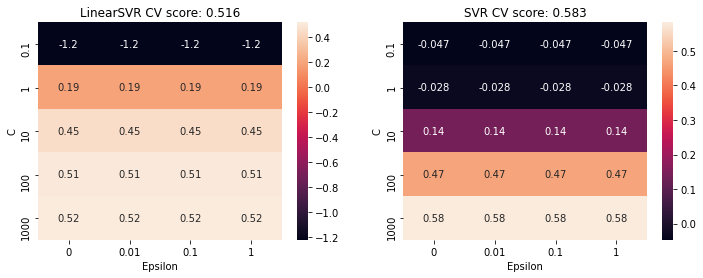

In [22]:
#will use polynomial extension on LinearSVR
lin_svr_ct = make_column_transformer(poly_degree=2, scaler=StandardScaler())

pipes = [Pipeline([('ct', lin_svr_ct), ('model', LinearSVR())]),
         Pipeline([('ct', ct), ('model', SVR())])]
#will tune C and epsilon
C = [0.1, 1, 10, 100, 1000]
epsilons = [0, 0.01, 0.1, 1]
grid_params = {'model__C': C,
               'model__epsilon': epsilons}
fig, axs = plt.subplots(1,2,figsize=(12,4))

for model, model_name, ax in zip(pipes, model_names, axs.ravel()):
    grid = GridSearchCV(model, grid_params, n_jobs=2)
    grid.fit(X_train_svr, y_train_svr)
    best_score = grid.best_score_
    results = grid.cv_results_['mean_test_score'].reshape(5,-1)
    sns.heatmap(results, annot=True, xticklabels=epsilons, 
                yticklabels=C, ax=ax)
    format_plots(ax, f'{model_name} CV score: {best_score:.3f}', 'Epsilon', 'C')

<b>Take-aways:</b>
1. Model isn't as respondive to epsilon values.  Epsilon controls the boundary width between which points don't contribute to loss.    
2. Higher C values result in better scores.  Higher C implies less regulazitaion and more weight to data points.  

C:\Users\a910045\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


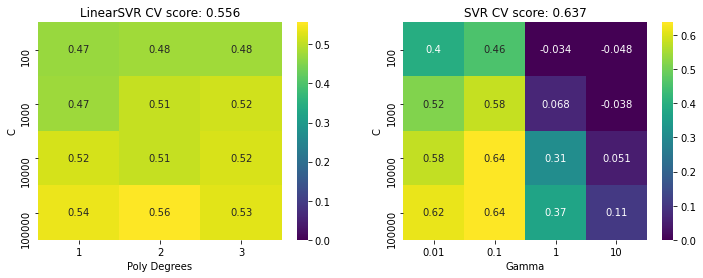

In [23]:
C = [100, 1000, 10000, 100000]
gamma = [0.01, 0.1, 1, 10]
degrees = [1, 2, 3]

SVR_grid_params = {'model__C': C,
                   'model__gamma': gamma}

linSVR_grid_params = {'model__C': C,
                      'ct__rest__poly__degree':degrees}

fig, axs = plt.subplots(1,2,figsize=(12,4))

for model, model_name, ax in zip(pipes, model_names, axs.ravel()):
    if model_name=='LinearSVR':
        grid_params = linSVR_grid_params
        x_label = 'Poly Degrees'
        x_ticks = degrees
    else:
        grid_params = SVR_grid_params
        x_label = 'Gamma'
        x_ticks = gamma
    grid = GridSearchCV(model, grid_params, n_jobs=2)
    grid.fit(X_train_svr, y_train_svr)
    best_score = grid.best_score_
    results = grid.cv_results_['mean_test_score'].reshape(4,-1)
    sns.heatmap(results, annot=True, xticklabels=x_ticks, 
                yticklabels=C, ax=ax, vmin=0, cmap='viridis')
    format_plots(ax, f'{model_name} CV score: {best_score:.3f}', x_label, 'C')

<b>Take-aways:</b>  
1. SVR performs better than LinearSVR  
2. Found performance envelope C=10,000, gamma=0.1

### Model Inspection / Feature Importances

SVR w/ rbf kerner Test Score: 0.693


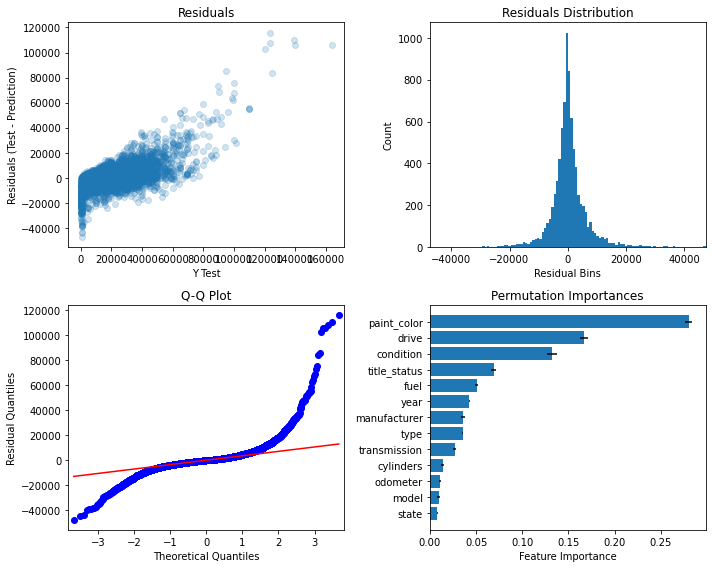

In [24]:
#will increase training set size and use test set to score and validation set for inspection
X_train_svr, X_val_svr, y_train_svr, y_val_svr = train_test_split(X_train, y_train, test_size=0.15,
                                                                  train_size=0.35, random_state=0)
svr = Pipeline([('ct', ct), ('model', SVR(C=10000, gamma=0.1))])
svr.fit(X_train_svr, y_train_svr)
score = svr.score(X_test, y_test)
print(f'SVR w/ rbf kerner Test Score: {score:.3f}')

#will use validation set to speed up the process for residuals and feature importances
fig, axs = plt.subplots(2, 2, figsize=(10,8))
ax1, ax2, ax3, ax4 = axs.ravel()

#inspecting residuals
y_predict = svr.predict(X_val_svr)
residuals_plots(ax1, ax2, ax3, y_val_svr, y_predict)

#Permutation imporance
plot_permutation_importances(ax4, svr, X_val_svr, y_val_svr)

fig.tight_layout()

<b>Take-aways:</b>
1. SVR with rbf kernel performs the best so far.  
2. Residual distribution is centered around 0, implies no systematic bias  
3. Residual distribution isn't normal and underpredicts values in Q3 and Q4 and overestimates in -Q3 and -Q4.  
4. Permutation imporances suggest similar results as with Linear models, but paint color and drive are swapped.  
5. General trend of under-estimating higher values and over-estimating lower persists just as with Linear model, but the residuals are smaller in value, hence better R2 score.

## Tree Based Algorithms

### Base

In [25]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

ct = ColumnTransformer([('target', TargetEncoder(), targ_cols + ohe)], remainder='passthrough')

models = [Pipeline([('ct', ct), ('model', RandomForestRegressor(n_jobs=-1))]),
          Pipeline([('ct', ct), ('model', GradientBoostingRegressor())])]

model_names = ['Random Forest', 'Gradient Boosting']
#no need to scale for tree based algorithms

print_model_scores(models, model_names, X_train, y_train)

Random Forest
R2: 0.779, MAE: 3353
Gradient Boosting
R2: 0.703, MAE: 4621


Tree based algorithms performed the best without even tuning

In [26]:
#helper functions
from sklearn.inspection import permutation_importance

def plot_residuals_perm_importance(model, model_name):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f'{model_name} Test Score: {score:.3f}')

    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    ax1, ax2, ax3, ax4 = axs.ravel()

    #inspecting residuals
    y_predict = model.predict(X_test)
    residuals_plots(ax1, ax2, ax3, y_test, y_predict)

    #Permutation imporance
    plot_permutation_importances(ax4, model, X_test, y_test)

    fig.tight_layout()

###  Random Forest

#### Model Tuning

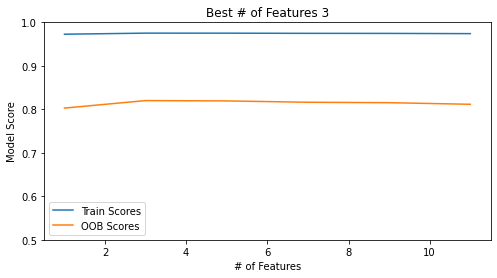

In [27]:
#tuning number of features first

train_scores = []
#random forests use bootstrapping principle to randomize trees
#bootstrapping uses about 66% of the data, out-of-bag is the subset of data that's not selected and could be used as validation set
oob_scores = []

#not using pipeline to save computational time, just need to transform once
pipe = Pipeline([('ct', ct), ('model', RandomForestRegressor(oob_score=True, n_estimators=100, 
                                                             random_state=0, n_jobs=-1))])
                              
feature_range = range(1, X_train.shape[1], 2)

#iterating over #of features to select for each split
for max_features in feature_range:
    pipe.set_params(model__max_features=max_features)
    pipe.fit(X_train, y_train)
    train_scores.append(pipe.score(X_train, y_train))
    #adding score for out-of-bag samples, similar to validation score
    oob_scores.append(pipe.named_steps['model'].oob_score_)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(feature_range, train_scores, label='Train Scores')
ax.plot(feature_range, oob_scores, label='OOB Scores')
ax.set_ylim(0.5, 1)
ax.legend()
best_features = list(feature_range)[np.argmax(oob_scores)]
format_plots(ax, f'Best # of Features {best_features}', '# of Features', 'Model Score')

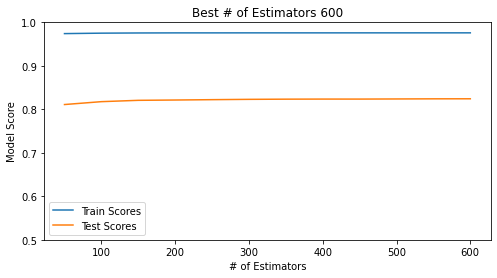

In [28]:
#tuning number of trees

train_scores = []
oob_scores = []

#using warm start to add additional tree without refitting the whole model, saves time
rf = RandomForestRegressor(warm_start=True, n_jobs=-1, max_features=best_features, oob_score=True)
#number of trees to try
estimator_range = range(50, 601, 50)
#converting X-train once to save computational time
X_train_transf = ct.fit_transform(X_train, y_train)

for n_estimators in estimator_range:
    rf.n_estimators = n_estimators
    rf.fit(X_train_transf, y_train)
    train_scores.append(rf.score(X_train_transf, y_train))
    oob_scores.append(rf.oob_score_)
    
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(estimator_range, train_scores, label='Train Scores')
ax.plot(estimator_range, oob_scores, label='Test Scores')
ax.set_ylim(0.5, 1)
ax.legend()
best_estimators=list(estimator_range)[np.argmax(oob_scores)]
format_plots(ax, f'Best # of Estimators {best_estimators}', '# of Estimators', 'Model Score')

Diminishing returns after 150 trees, will stick with 150 estimators and 3 features.  

Now need to tune max depth

In [29]:
max_depth = max(estimator.get_depth() for estimator in rf.estimators_)
print(f'Max depth of last trained forest: {max_depth}')

Max depth of last trained forest: 49


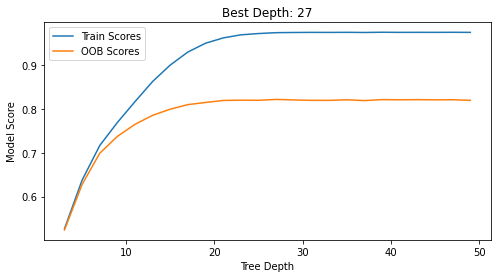

In [30]:
train_scores = []
oob_scores = []
depths = range(3,50,2)

#iterating over #of features to select for each split
for depth in depths:
    rf = RandomForestRegressor(max_depth=depth, max_features=3, oob_score=True,
                                n_estimators=150, n_jobs=-1)
    rf.fit(X_train_transf, y_train)
    train_scores.append(rf.score(X_train_transf, y_train))
    oob_scores.append(rf.oob_score_)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(depths, train_scores, label='Train Scores')
ax.plot(depths, oob_scores, label='OOB Scores')
ax.legend()
best_depth = list(depths)[np.argmax(oob_scores)]
format_plots(ax, f'Best Depth: {best_depth}', 'Tree Depth', 'Model Score')

No notable improvement after depth of 23, will stick with 23 max depth to speed up the algorithm

#### Model Inspection / Feature Importances

Random Forest Test Score: 0.809


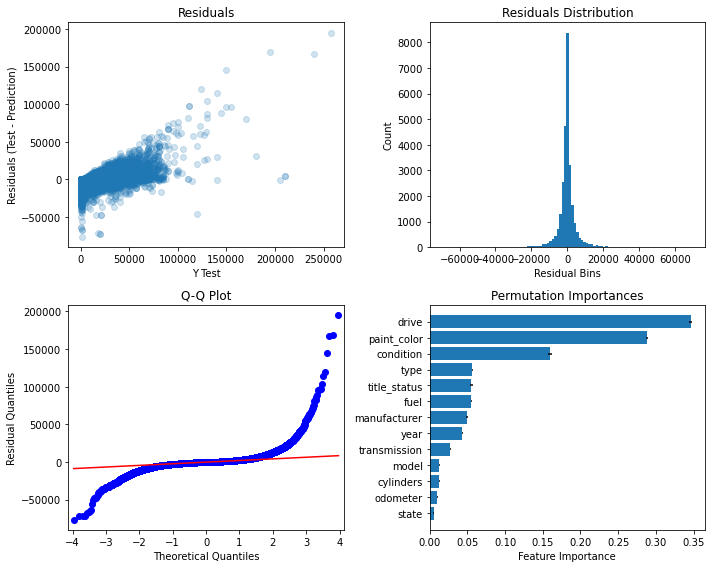

In [31]:
rf_pipe = Pipeline([('ct', ct), ('model', RandomForestRegressor(n_jobs=-1, max_features=3, 
                                                                n_estimators=150, max_depth=23))])
plot_residuals_perm_importance(rf_pipe, 'Random Forest')

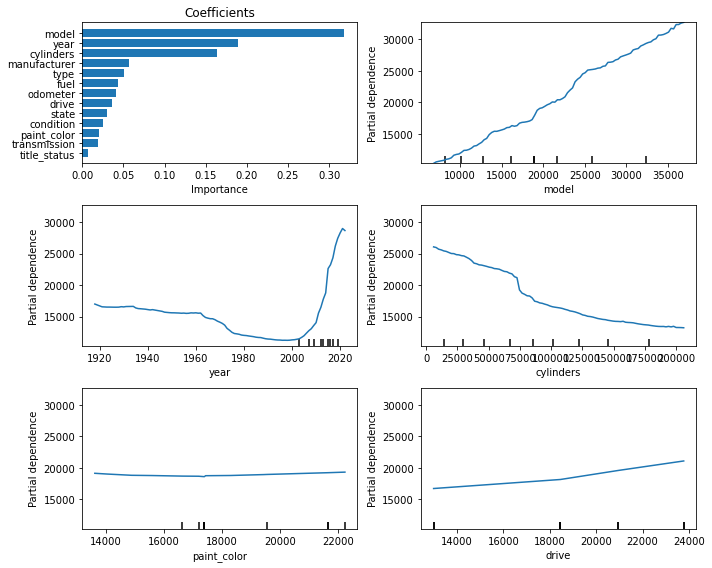

In [32]:
from sklearn.inspection import plot_partial_dependence

coef_names = np.array(rf_pipe.named_steps['ct'].named_transformers_['target'].get_feature_names() + cont)
coefs = rf_pipe.named_steps['model'].feature_importances_
coef_order = coefs.argsort()
fig, axs = plt.subplots(3,2, figsize=(10, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.ravel()

#plotting naive feature importances (coefficients)
ax1.barh(coef_names[coef_order], coefs[coef_order])
format_plots(ax1, 'Coefficients', 'Importance')

#plotting partial dependence
#need to get the mode from pipeline so can utilize recursion vs brute force
model = rf_pipe.named_steps['model']
#need to transform the data before passing to partial dependence
ct.fit(X_train, y_train)
feature_names= targ_cols + ohe +cont
plot_partial_dependence(model, ct.transform(X_test), 
                        [1, 10, 12, 3, 5], feature_names=feature_names, 
                        method='recursion', ax=[ax2, ax3, ax4, ax5, ax6])
fig.tight_layout()

<b>Take-aways:</b>  
1. Similar results as previous for residuals  
2. Permutation importance shows similar results as prior models  
3. Partial dependence is showing the opposite results  
  
  
Partial dependence is in line with coef_importances and tells us how the model responds on average with changing feature values.  However it doesn't capture other feature interactions, so should be analyzed with care.  If model had such a big impact shuffling models column should have decreased model score, however that's not evident from permutation importances.  Interactions of drive type and paint_color with other features are most likely what drive an increase in permutation importance.

### Gradient Boosting

#### Model Tuning

In [33]:
pipe = Pipeline([('ct', ct), ('model', GradientBoostingRegressor())])
#no need to scale for tree based algorithms

#getting base scores
print_model_scores([pipe], ['Gradient Boosting'], X_train, y_train)

Gradient Boosting
R2: 0.703, MAE: 4620


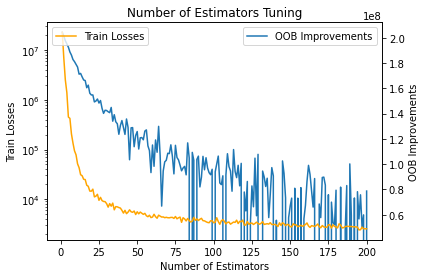

In [34]:
#will run the model with 150 estimators and see improvements in loss values
#loss values will show an inverse of R2 plot, therefore looking for minimum instead of maximum score

#subsampling to use out of bag scores
num_estimators = 200
gb = GradientBoostingRegressor(subsample=0.7, n_estimators=num_estimators)
pipe = Pipeline([('ct', ct), ('model', gb)])
pipe.fit(X_train, y_train)
#saving imporvements in oob scores from previous iterations
oob_improve = pipe.named_steps['model'].oob_improvement_
train_scores = pipe.named_steps['model'].train_score_
plt.plot(range(1, num_estimators+1), oob_improve, label='OOB Improvements')
ax = plt.gca()
ax.set_yscale('log')
ax2 = ax.twinx()

ax2.plot(range(1, num_estimators+1), train_scores, label='Train Losses', c='orange')
format_plots(ax2, y_label='OOB Improvements')
format_plots(ax, 'Number of Estimators Tuning', 'Number of Estimators', 'Train Losses')

ax.legend()
ax2.legend(loc='upper left')
plt.show()

1. Train losses keep decreasing with number of estimators, that's intuative because the model starts to overfit.  
2. OOB Improvements stay relatively flat after 150 estimators.  

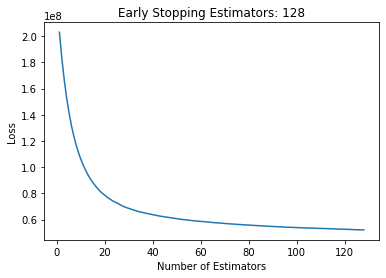

In [35]:
#now will explore early stopping to see how many estimators will get
gb = GradientBoostingRegressor(validation_fraction=0.2, n_iter_no_change=3, n_estimators=300, tol=0.001)
pipe = Pipeline([('ct', ct), ('model', gb)])
pipe.fit(X_train, y_train)
train_scores = pipe.named_steps['model'].train_score_
plt.plot(range(1, len(train_scores)+1), train_scores)
estimators = pipe.named_steps['model'].n_estimators_
format_plots(plt.gca(), f'Early Stopping Estimators: {estimators}', 'Number of Estimators', 'Loss')

<b>Both methods suggest upwards of 150 trees, therefore will use the highest from early stopping - 190 estimators

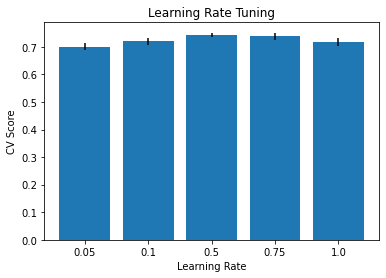

In [36]:
#now tuning learning rate
gb = GradientBoostingRegressor(n_estimators=190)
pipe = Pipeline([('ct', ct), ('model', gb)])
learn_rates = [0.05, 0.1, 0.5, 0.75, 1]
param_grid = {'model__learning_rate': learn_rates}
grid = GridSearchCV(pipe, param_grid=param_grid)
grid.fit(X_train, y_train)
results = grid.cv_results_['mean_test_score']
std = grid.cv_results_['std_test_score']
plt.bar(range(0, len(learn_rates)), results, yerr=std, tick_label=learn_rates)
format_plots(plt.gca(), f'Learning Rate Tuning', 'Learning Rate', 'CV Score')

#### Model Inspection / Feature Importances

Gradient Boosting Test Score: 0.738


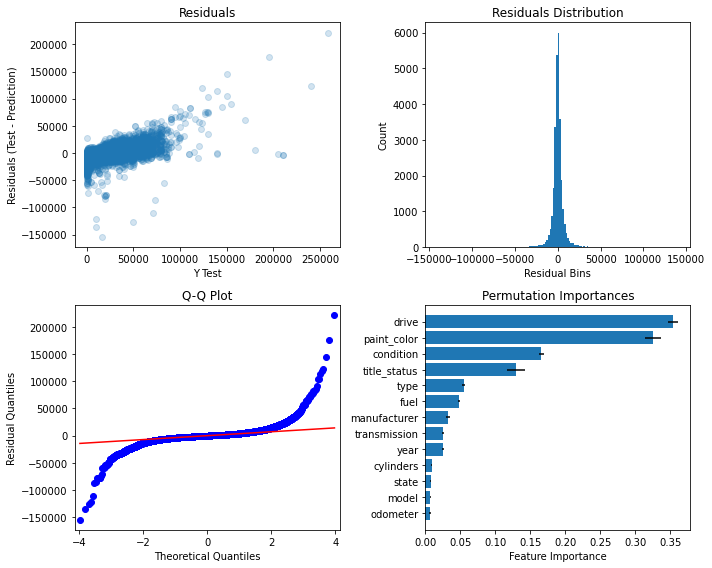

In [37]:
gb = GradientBoostingRegressor(n_estimators=190, learning_rate=0.5)
gb_pipe = Pipeline([('ct', ct), ('model', gb)])
plot_residuals_perm_importance(gb_pipe, 'Gradient Boosting')

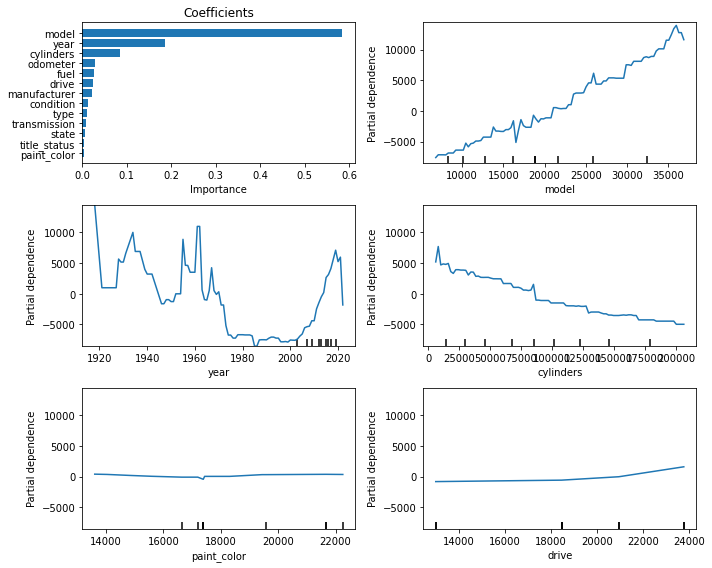

In [38]:
coef_names = np.array(gb_pipe.named_steps['ct'].named_transformers_['target'].get_feature_names() + cont)
coefs = gb_pipe.named_steps['model'].feature_importances_
coef_order = coefs.argsort()
fig, axs = plt.subplots(3,2, figsize=(10, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.ravel()

#plotting naive feature importances (coefficients)
ax1.barh(coef_names[coef_order], coefs[coef_order])
format_plots(ax1, 'Coefficients', 'Importance')

#plotting partial dependence
#need to get the mode from pipeline so can utilize recursion vs brute force
model = gb_pipe.named_steps['model']
#need to transform the data before passing to partial dependence
ct.fit(X_train, y_train)
feature_names= targ_cols + ohe +cont
plot_partial_dependence(model, ct.transform(X_test), 
                        [1, 10, 12, 3, 5], feature_names=feature_names, 
                        method='recursion', ax=[ax2, ax3, ax4, ax5, ax6])
fig.tight_layout()

Similar results with Random Forest, but the model didn't perform as well

# Feature Selection

Random forest performed the best out of the rest with Test score of 0.8.  
Now moving onto feature selection to reduce model size

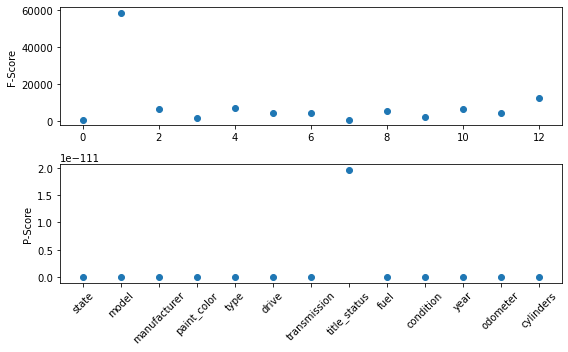

In [39]:
from sklearn.feature_selection import f_regression
X_train_transf = ct.fit_transform(X_train, y_train)
f_values, p_values = f_regression(X_train_transf, y_train)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,5))
ax1.scatter(range(len(targ_cols + ohe + cont)), f_values)
ax1.set_ylabel('F-Score')
ax2.scatter(targ_cols + ohe + cont, p_values)
ax2.set_ylabel('P-Score')

ax2.tick_params(axis='x', rotation=45)

fig.tight_layout()

1. High F score rejects null hypothesis:  
        The null hypothesis states that the model with no independent variables fits the data as well as your model.  
        The alternative hypothesis says that your model fits the data better than the intercept-only model.
2. The opposite is true for P score:  
         The null hypothesis that the variable has no correlation with the dependent variable.  
  
Need to excerise caution because these tests assume linear relationship.  Does give insight into Title_status.  Title status doesn't contribute much based on both tests.  P-scores are all well below 0.05 (usual thershold), but the relationships between target and each feature are also not linear.

In [104]:
#will run model with and without title status
from sklearn.feature_selection import SelectKBest
ct = ColumnTransformer([('target', TargetEncoder(), targ_cols + ohe)], remainder='passthrough')
rf_pipe = Pipeline([('ct', ct), ('model', RandomForestRegressor(max_features=3, 
                                                                n_estimators=150, max_depth=23))])

print('CV times with all features:')
all_feature_score = cross_val_score(rf_pipe, X_train, y_train, verbose=True).mean()

k=9
#adding feature selection to existing pipeline
rf_pipe.steps.insert(1, ('feat_select', SelectKBest(k=k, score_func=f_regression)))

print(f'CV times with {k} features:')
feat_select_score = cross_val_score(rf_pipe, X_train, y_train, verbose=True).mean()
print(f'All features score: {all_feature_score:.3f}')
print(f'Top {k} features score: {feat_select_score:.3f}')

#selected features
rf_pipe.fit(X_train, y_train)
features = np.array(targ_cols + ohe + cont)
print('Dropped Features: ', features[~rf_pipe.named_steps['feat_select'].get_support()])
score = rf_pipe.score(X_test, y_test)
print(f'Test Score with {k} features: {score:.3f}')

CV times with all features:


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CV times with 9 features:


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.5s finished


All features score: 0.791
Top 9 features score: 0.784
Dropped Features:  ['state' 'paint_color' 'title_status' 'condition']
Test Score with 9 features: 0.803


<b>No change to test score by dropping 3 features, but model computational times don't impove much either.</b>  
No imporvement in computational time can be explained by underlying priciples of RF.  Since RF picks a split based on the features that decrease impurity the most, the algorithm doesn't pick unimportant features to decide the splits to begin with.  Therefore excluding those columns won't have much of an impact.  
  
RF Impurities:  
1. MSE in case of Regression  
2. Gini or Cross-Entropy for Classification

In [108]:
from sklearn.feature_selection import SelectFromModel
#will select from most important features based on small random forest
max_feat = 9
select_lin_reg = SelectFromModel(RandomForestRegressor(n_estimators=50, max_depth=5, n_jobs=-1), 
                                 threshold=-np.inf, max_features=max_feat)
rf_pipe.steps[1] = ('feat_select', select_lin_reg)
score = cross_val_score(rf_pipe, X_train, y_train).mean()

print(f'Selected {max_feat} highest features from Random Forest, CV score: {score:.3f}')

rf_pipe.fit(X_train, y_train)
features = np.array(targ_cols + ohe + cont)
print('Selected Features: ', features[~rf_pipe.named_steps['feat_select'].get_support()])

Selected 9 highest features from Random Forest, CV score: 0.785
Selected Features:  ['state' 'paint_color' 'type' 'title_status']


In [119]:
from sklearn.feature_selection import RFECV

rfe = RFECV(LinearRegression())
X_train_scaled = ct.transform(X_train)
X_train_scaled = StandardScaler().fit_transform(X_train_scaled)
rfe.fit(X_train_scaled, y_train)
num_feat = rfe.get_support().sum()
print(f'Selected {num_feat} Features from Linear Regression Recursive Feature Elimination')

Selected 13 Features from Linear Regression Recursive Feature Elimination
